In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from bokeh.plotting import ColumnDataSource, figure
from bokeh.layouts import row
from sklearn.model_selection import train_test_split
from bokeh.io import output_file, show
from pickle import dump
import math
from numpy.linalg import inv
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# making an image by pixels

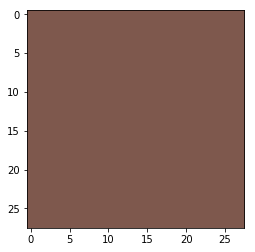

In [2]:
b=77  
g=88  
r=126

# r, g, and b are 512x512 float arrays with values >= 0 and < 1.

rgbArray = np.zeros((28,28,3), 'uint8')
rgbArray[..., 0] = r#*256
rgbArray[..., 1] = g#*256
rgbArray[..., 2] = b#*256
img = Image.fromarray(rgbArray)
#img.save('myimg.jpeg')

imgplot = plt.imshow(img)

# Loading Dataset

In [3]:
test_size_param = 0.2
test_size =int((145185*20)/100)

dataset = pd.read_csv('train_all.csv') #, encoding='utf-8' ,index_col=0)
dataset.head()

,id,B,G,R,class
0,1,74,85,123,1
1,2,73,84,122,1
2,3,72,83,121,1
3,4,70,81,119,1
4,5,70,81,119,1


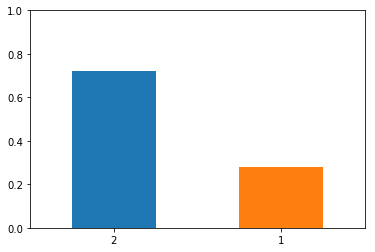

In [4]:
#without learning , accuracy will be more than 70%  :"D
#i will get more than 70% if i just classify each class belong to class 2
dataset['class'].value_counts(normalize=True)

dataset["class"].value_counts(normalize=True).plot(kind="bar", yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], rot=0)
#plt.savefig('unpalanced_data.png', bbox_inches='tight')

### shuffle the dataset

In [5]:
from sklearn.utils import shuffle
shuffled_dataset = shuffle(dataset, random_state = 0)
shuffled_dataset.head(10)

training_set = shuffled_dataset[test_size:]
testing_set = shuffled_dataset[0:test_size]


X_test = testing_set.iloc[:,1:4]
Y_test = testing_set.iloc[:,4]

X_train = training_set.iloc[:,1:4]
Y_train = training_set.iloc[:,4]

In [6]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis(store_covariance=True)

qda.fit(X_train, Y_train)

'''
X_pred = pd.read_csv('test_all.csv')
y_pred = qda.predict(X_pred.iloc[:, 1:4])


my_submission = pd.DataFrame({'Id': X_pred.iloc[:,0], 'class': y_pred})
# you could use any filename. We choose submission here
my_submission.to_csv('submission0.csv', index=False)
'''
print("QDA Priors : "+str(qda.priors_))
print("QDA Decision Function : "+str(qda.decision_function(X_train)))
print("QDA Score : "+str(qda.score(X_test, Y_test)))


QDA Priors : [0.28040706 0.71959294]
QDA Decision Function : [48.54728706 51.56429404 43.53913177 ... 11.53488716 47.42043019
 41.83218136]
QDA Score : 0.9843303371560423


# Building QuadraticDiscriminantAnalysis (QDA)

In [7]:
#You have to separate the two classes
#Skin class
class1 = training_set[training_set['class'] == 1]
#non_skin class
class2 = training_set[training_set['class'] == 2]

print(class1.describe())
print(class2.describe())

                 id             B             G             R    class
count  32569.000000  32569.000000  32569.000000  32569.000000  32569.0
mean   20347.481224    113.211305    145.379011    201.116860      1.0
std    11742.867422     45.655726     39.389410     40.938203      0.0
min        1.000000     28.000000     58.000000    106.000000      1.0
25%    10193.000000     69.000000    107.000000    165.000000      1.0
50%    20338.000000    119.000000    150.000000    217.000000      1.0
75%    30492.000000    151.000000    181.000000    232.000000      1.0
max    40687.000000    225.000000    230.000000    255.000000      1.0
                  id             B             G             R    class
count   83580.000000  83580.000000  83580.000000  83580.000000  83580.0
mean    92866.466798    122.754152    120.718832     94.348504      2.0
std     30183.186782     70.013424     68.079268     66.623958      0.0
min     40688.000000      0.000000      0.000000      0.000000      2.0
2

In [8]:
#Calculate the mean of each class
class1_mu = (class1[['B', 'G', 'R']].mean(axis=0)).values
class2_mu = (class2[['B', 'G', 'R']].mean(axis=0)).values


#Calculate the standard deviation of each class
class1_sigma = (class1[['B', 'G', 'R']].cov()).values
class2_sigma = (class2[['B', 'G', 'R']].cov()).values

#Inverse the standard deviation of each class
class1_sigmaInv =inv(class1_sigma)
class2_sigmaInv =inv(class2_sigma)

#Calculate the threshold
p1 = class1.shape[0]/training_set.shape[0]
p2 = class2.shape[0]/training_set.shape[0]

th = math.log(p2/p1)

t1=np.dot(np.dot(class2_mu.T, class2_sigmaInv),class2_mu)
t2=np.dot(np.dot(class1_mu.T, class1_sigmaInv),class1_mu)
term=t1-t2

### Evaluate the QDA

In [9]:
def score( x ):
    quadratic = np.dot(np.dot(x.T,(class2_sigmaInv - class2_sigmaInv)),x)
    linear = 2*np.dot(x.T,np.reshape(np.dot(class2_sigmaInv,class2_mu)-np.dot(class1_sigmaInv,class1_mu),(3,1)))
    return quadratic-linear+term
   
def classify (h_x):
    if(h_x > th):
        return 1
    else:
        return 2


y_score = np.apply_along_axis( score, axis=1, arr=X_test.values )

y_pred =np.apply_along_axis(classify, axis=1, arr= y_score)

print("Accuracy: "+str(sum(y_pred==Y_test)*100/X_test.shape[0]))

Accuracy: 95.63660157729792


In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, y_pred)
print("Confusion matrix of the implemented QDA:")
print(cm)

Confusion matrix of the implemented QDA:
[[ 8113     5]
 [ 1262 19657]]


In [11]:
from sklearn.metrics import confusion_matrix
lin_cm = confusion_matrix(Y_test, qda.predict(X_test))
print("Confusion matrix of the built-in QDA:")
print(lin_cm)

Confusion matrix of the built-in QDA:
[[ 7739   379]
 [   76 20843]]


# Building KNN

In [12]:
neighbors = 3

knn = KNeighborsClassifier(n_neighbors=neighbors)
knn.fit(X_train, Y_train) 
y_predKnn = knn.predict(X_test)

cm_knn = confusion_matrix(Y_test, y_predKnn)

print("Confusion matrix of the Knn model:")
print(cm_knn)

Confusion matrix of the Knn model:
[[ 8118     0]
 [    9 20910]]


# Building LogisticRegression

In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, Y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, Y_test)))

Accuracy of Logistic regression classifier on training set: 0.93
Accuracy of Logistic regression classifier on test set: 0.93


# Building SVM

In [14]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, Y_train)
print ('SVM classifier score : ', clf.score(X_test, Y_test))
print ('Pred label : ', clf.predict(X_test))

SVM classifier score :  0.9954885146537177
Pred label :  [1 2 2 ... 2 1 1]


# Visualizations

### countplot

C:\Users\Ali\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


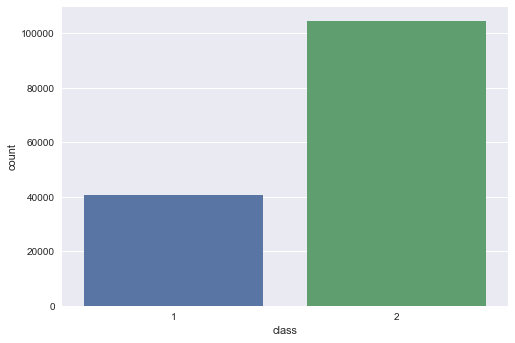

In [22]:
import seaborn as sns
import pylab as pl
from pandas.tools.plotting import scatter_matrix
from matplotlib import cm

sns.countplot(dataset['class'],label="Count")
plt.show()

### Box plot

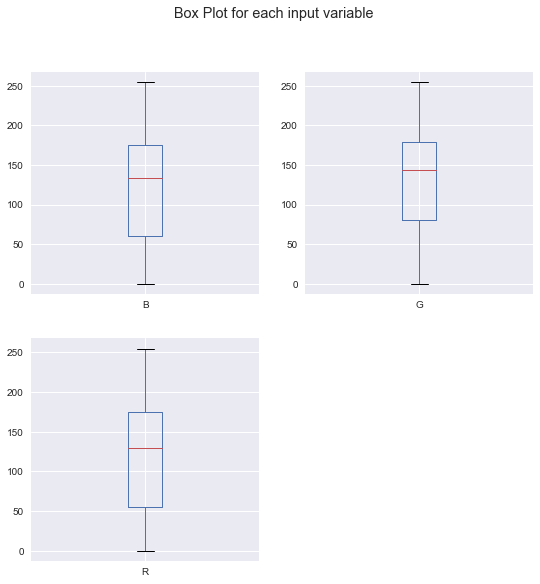

In [33]:
dataset.drop(['class', 'id'], axis=1).plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False, figsize=(9,9), 
                                        title='Box Plot for each input variable')
plt.savefig('Box_plot.png')
plt.show()

### Histogram plot

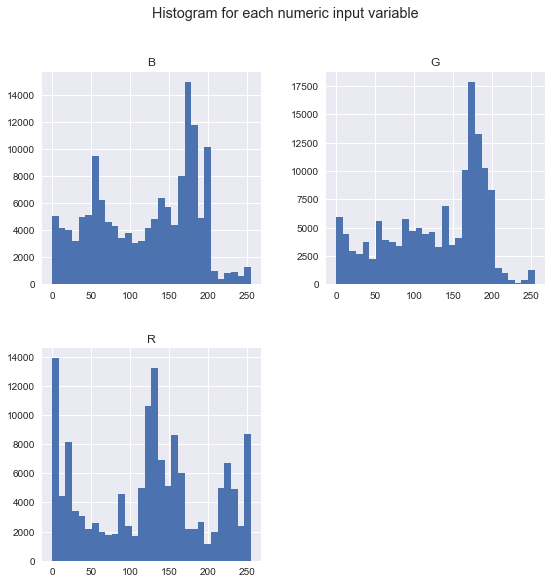

In [24]:
dataset.drop(['class', 'id'] ,axis=1).hist(bins=30, figsize=(9,9))
pl.suptitle("Histogram for each numeric input variable")
plt.savefig('RGB_hist')
plt.show()

### Scatter matrix plot

C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """


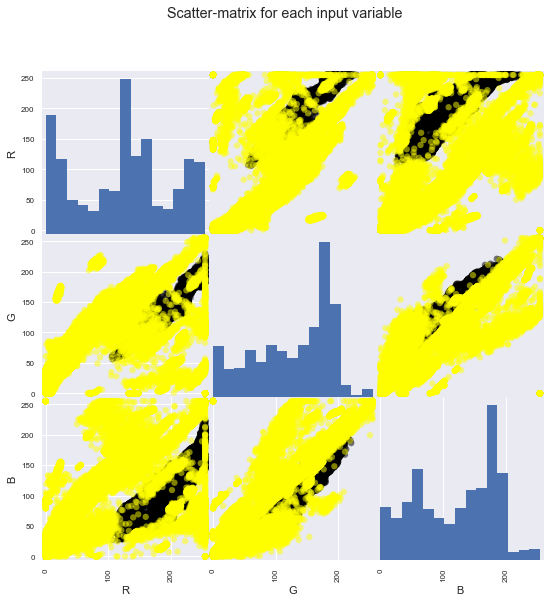

In [25]:
feature_names = ['R', 'G', 'B']
X = dataset[feature_names]
y = dataset['class']
cmap = cm.get_cmap('gnuplot')
scatter = pd.scatter_matrix(X, c = y, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9), cmap = cmap)
plt.suptitle('Scatter-matrix for each input variable')
plt.savefig('RGB_scatter_matrix')
plt.show()

### visualize the relationship between the features and the response using scatterplots


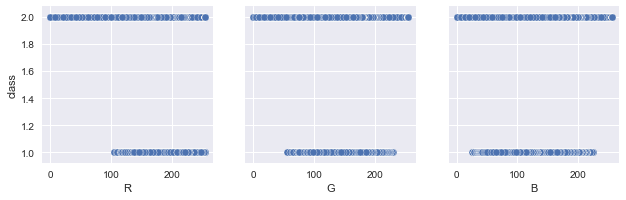

In [26]:
sns.pairplot(dataset, x_vars=['R', 'G', 'B'], y_vars='class', size=3)#, aspect=0.7
plt.show()

### Histogram of predicted probabilities

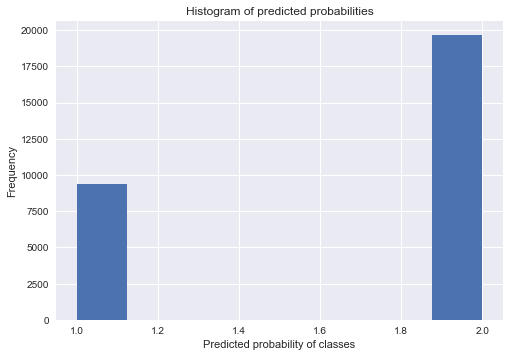

In [35]:
# 8 bins
plt.hist(y_pred, bins=8)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of classes')
plt.ylabel('Frequency')
plt.show()

# Compare Algorithms

In [15]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('SVM', SVC()))

neighbors = 3 
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state= 7)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.933534 (0.002647)
KNN: 0.999707 (0.000189)
QDA: 0.982867 (0.000995)
SVM: 0.994559 (0.000798)


### Boxplot for algorithm comparison

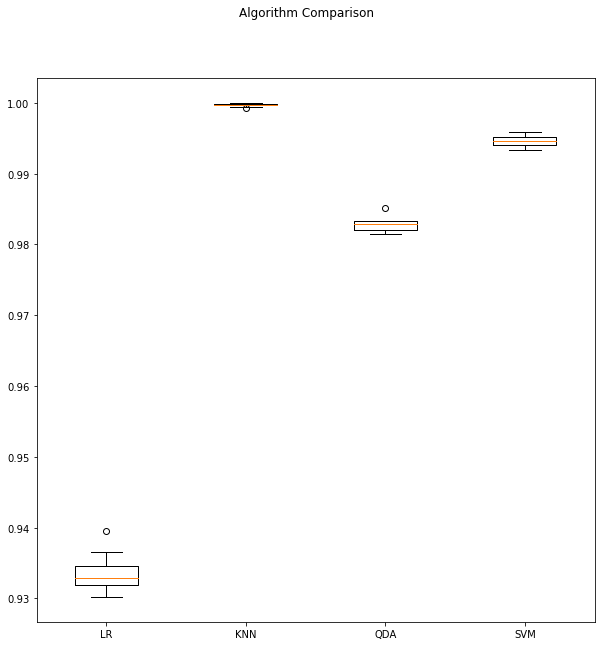

In [16]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
#plt.savefig('algorithms_comparision')
plt.show()
